In [1]:
import os
import random
import re
from copy import deepcopy
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, f1_score, classification_report



SEED = 52
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [2]:
df = pd.read_csv("goodreads_data.csv")

print(df.shape)         
print(df.columns)        

(10000, 8)
Index(['Unnamed: 0', 'Book', 'Author', 'Description', 'Genres', 'Avg_Rating',
       'Num_Ratings', 'URL'],
      dtype='object')


# Pradinė analizė

In [3]:
df.isnull().sum() #yra praleistu reiksmiu jas pasaliname


Unnamed: 0      0
Book            0
Author          0
Description    77
Genres          0
Avg_Rating      0
Num_Ratings     0
URL             0
dtype: int64

In [4]:
df = df.dropna()

df.count() 

Unnamed: 0     9923
Book           9923
Author         9923
Description    9923
Genres         9923
Avg_Rating     9923
Num_Ratings    9923
URL            9923
dtype: int64

In [5]:
# kiek is viso pradzioje turime zanru

df['Genres'] = df['Genres'].str.replace('[\[\]\']', '', regex=True)

all_genres = []
for genres in df['Genres']:
    all_genres.extend([g.strip() for g in genres.split(',') if g.strip() != ''])

unique_genres = sorted(set(all_genres))

for genre in unique_genres:
    print(genre)

print(f"\nIš viso unikalių žanrų: {len(unique_genres)}")

len(df)


12th Century
15th Century
16th Century
17th Century
18th Century
19th Century
20th Century
21st Century
Abuse
Academia
Academic
Action
Activism
Adhd
Adoption
Adult
Adult Fiction
Adventure
Africa
African American
African American Literature
African Literature
Agriculture
Alchemy
Algeria
Aliens
Alternate History
Alternate Universe
Amazon
American
American Civil War
American History
American Revolution
American Revolutionary War
Americana
Amish
Anarchism
Ancient
Ancient History
Angels
Animal Fiction
Animals
Anthologies
Anthropology
Anti Racist
Apocalyptic
Archaeology
Architecture
Art
Art Design
Art History
Arthurian
Artificial Intelligence
Asexual
Asia
Asian Literature
Astrology
Astronomy
Atheism
Audiobook
Australia
Autistic Spectrum Disorder
Autobiography
Aviation
BDSM
Bande Dessinée
Banned Books
Baseball
Basketball
Batman
Beauty and The Beast
Biblical Fiction
Biography
Biography Memoir
Biology
Birds
Bizarro Fiction
Boarding School
Book Club
Books About Books
Botswana
Brain
Brazil
Britis

9923

In [6]:
# pasaliname tuscius zanrus, kurie buvo pamineti kaip [] ir neskaite kaip NA
df = df[df["Genres"] != ""]

df.count()

Unnamed: 0     9000
Book           9000
Author         9000
Description    9000
Genres         9000
Avg_Rating     9000
Num_Ratings    9000
URL            9000
dtype: int64

In [7]:
#zanrai kurie pasitaiko tik vinea karta, t.y. tariamas zanras priskirtas tik viena karta vienai knygai

# Paverciame genres i sarasus 
df['Genres_list'] = df['Genres'].apply(lambda x: [g.strip() for g in x.strip('[]').replace("'", "").split(',') if g.strip() != ''])

# Suskaiciuojame kiek kartu kiekvienas zanras pasirodo
all_genres = [genre for sublist in df['Genres_list'] for genre in sublist]
genre_counts = Counter(all_genres)

# Surandame zanrus, kurie pasitaiko tik viena karta
rare_genres = [genre for genre, count in genre_counts.items() if count == 1]

print("Žanrai, kurie pasitaiko tik vieną kartą:")
print(rare_genres)


Žanrai, kurie pasitaiko tik vieną kartą:
['Liberia', 'Sierra Leone', 'Own', 'Fostering', 'Police', 'Counter Culture', 'Satanism', 'Counting', 'Transport', 'Eugenics', 'Guidebook', 'Social Work', 'Gods', 'Chemistry', 'Botswana', 'Somalia', 'Alchemy', '12th Century', 'Academic', 'Morocco', 'Mountaineering', 'Diets', 'Emotion', 'Video Games', 'Polyamory', 'Lds Non Fiction', 'Home Economics', 'Short Story Collection', 'Cycling', 'Zimbabwe', 'Fat Studies', 'Fat', 'Fat Acceptance', 'Adhd', 'Social', 'Horse Racing', 'Go', 'Biblical Fiction', 'Nursery Rhymes', 'Divorce', 'Gothic Horror', 'Star Trek', 'Womens Studies', 'Christian Historical Fiction', 'Serbian Literature', 'Flash Fiction', 'Tv', 'M M F', 'Weird West', 'Soccer', 'Tragedy', 'Logic', 'Tea', 'Danish', 'Drawing', 'Superman', 'Genderfluid', 'Climate Change Fiction', 'Poetry Plays', 'Palaeontology', 'Seinen', 'Dungeons and Dragons', 'Street Art', 'Dying Earth', 'Crafts', 'Programming', 'Technical', 'Software', 'Hard Science Fiction', '

Pašaliname žanrus, kurie turi mažiau nei 300 knygų. Bet paliekame tas knygas, kurios turėjo kitus populiarius žanrus, t.y. joms sumažinamas žanru skaičius.

In [8]:
# Genres paverciame i list
df['Genres_list'] = df['Genres'].apply(
    lambda x: [g.strip() for g in str(x).strip('[]').replace("'", "").split(',') if g.strip() != ""]
)

# Suskaiciuojame visus zanrus
all_genres = [genre for sublist in df['Genres_list'] for genre in sublist]
genre_counts = Counter(all_genres)

# Tik zanrai, kurie pasirodo >=300 kartu
popular_genres = {genre for genre, count in genre_counts.items() if count >= 300}

# Filtruojame zanru sarasus
df['Genres_list'] = df['Genres_list'].apply(
    lambda genres: [g for g in genres if g in popular_genres]
)

# Pašaliname tuscius irasus
df = df[df['Genres_list'].map(len) > 0]

print("Po filtravimo liko knygų:", len(df))

# Unikalus zanrai (po filtravimo)
unique_genres = sorted(popular_genres)

print("\nUnikalūs žanrai:")
for g in unique_genres:
    print(g)

print(f"\nIš viso unikalių žanrų: {len(unique_genres)}")

total_genres = len(genre_counts)
print(f"Iš viso žanrų: {total_genres}")
rare_genres = {genre for genre, count in genre_counts.items() if count < 300}
print(f"Iš viso retų žanrų: {len(rare_genres)}")

Po filtravimo liko knygų: 8889

Unikalūs žanrai:
Adult
Adventure
Audiobook
Biography
Business
Childrens
Classics
Contemporary
Crime
Drama
Dystopia
Fantasy
Fiction
Historical
Historical Fiction
History
Horror
Humor
Literary Fiction
Literature
Magic
Memoir
Middle Grade
Mystery
Mystery Thriller
Nonfiction
Novels
Paranormal
Personal Development
Philosophy
Politics
Psychology
Religion
Romance
Science
Science Fiction
Science Fiction Fantasy
Self Help
Short Stories
Spirituality
Suspense
Thriller
War
Young Adult

Iš viso unikalių žanrų: 44
Iš viso žanrų: 617
Iš viso retų žanrų: 573


Patikriname ar teisingai suveikė kodas - ar liko tik tie žanrai, kurie turi daugiau nei 300 knygų.

In [9]:
# Suskaičiuojame visus žanrus
all_genres = [g for sublist in df['Genres_list'] for g in sublist]
genre_counts = Counter(all_genres)

# Rikiuojame nuo dažniausių
for genre, count in genre_counts.most_common():
    print(f"{genre}: {count} knygų")



Fiction: 5686 knygų
Nonfiction: 2323 knygų
Fantasy: 2192 knygų
Classics: 2123 knygų
Romance: 1552 knygų
Young Adult: 1520 knygų
Historical Fiction: 1481 knygų
Mystery: 1357 knygų
Contemporary: 1290 knygų
Audiobook: 1242 knygų
Novels: 1159 knygų
Literature: 1108 knygų
Thriller: 1019 knygų
Historical: 942 knygų
Science Fiction: 844 knygų
History: 818 knygų
Adventure: 749 knygų
Philosophy: 740 knygų
Biography: 720 knygų
Self Help: 711 knygų
Crime: 699 knygų
Psychology: 693 knygų
Adult: 673 knygų
Mystery Thriller: 667 knygų
Childrens: 642 knygų
Memoir: 609 knygų
Humor: 561 knygų
Suspense: 524 knygų
Horror: 500 knygų
Paranormal: 488 knygų
Science Fiction Fantasy: 435 knygų
Personal Development: 414 knygų
Middle Grade: 412 knygų
Religion: 410 knygų
Literary Fiction: 405 knygų
Drama: 402 knygų
Business: 397 knygų
Politics: 393 knygų
Short Stories: 360 knygų
Science: 356 knygų
Spirituality: 348 knygų
War: 344 knygų
Magic: 327 knygų
Dystopia: 325 knygų


In [10]:
# Pasaliname nereiksminga zanra - audiobooks
df['Genres_list'] = df['Genres_list'].apply(lambda genres: [g for g in genres if g != "Audiobook"])


Counter({'Fiction': 5686, 'Nonfiction': 2323, 'Fantasy': 2192, 'Classics': 2123, 'Romance': 1552, 'Young Adult': 1520, 'Historical Fiction': 1481, 'Mystery': 1357, 'Contemporary': 1290, 'Novels': 1159, 'Literature': 1108, 'Thriller': 1019, 'Historical': 942, 'Science Fiction': 844, 'History': 818, 'Adventure': 749, 'Philosophy': 740, 'Biography': 720, 'Self Help': 711, 'Crime': 699, 'Psychology': 693, 'Adult': 673, 'Mystery Thriller': 667, 'Childrens': 642, 'Memoir': 609, 'Humor': 561, 'Suspense': 524, 'Horror': 500, 'Paranormal': 488, 'Science Fiction Fantasy': 435, 'Personal Development': 414, 'Middle Grade': 412, 'Religion': 410, 'Literary Fiction': 405, 'Drama': 402, 'Business': 397, 'Politics': 393, 'Short Stories': 360, 'Science': 356, 'Spirituality': 348, 'War': 344, 'Magic': 327, 'Dystopia': 325})


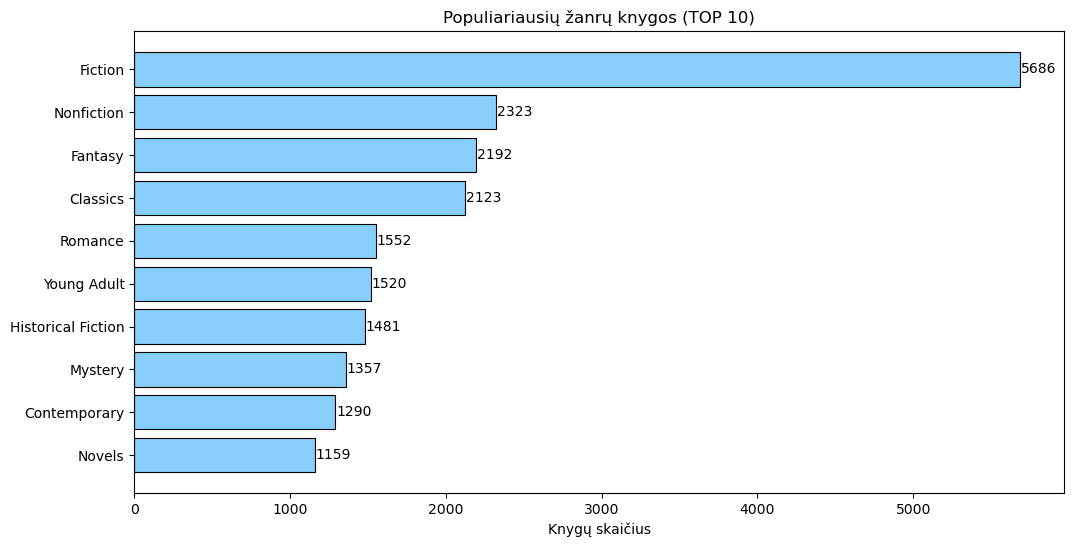

In [11]:
# Suskaičiuojame visus zanrus is Genres_list
all_genres_no_audiobook = [g for sublist in df['Genres_list'] for g in sublist]

genre_counts = Counter(all_genres_no_audiobook)
print(genre_counts)

# TOP 10 žanrų
top_genres = genre_counts.most_common(10)
genres, counts = zip(*top_genres)


plt.figure(figsize=(12,6))
plt.barh(genres, counts, color="lightskyblue",  edgecolor="black", linewidth=0.8)
plt.xlabel("Knygų skaičius")
plt.title("Populiariausių žanrų knygos (TOP 10)")
plt.gca().invert_yaxis()

for i, count in enumerate(counts):
    plt.text(count + 5, i, str(count), va='center')

plt.show()


In [12]:
# Suskaičiuojame, kiek žanrų turi kiekviena knyga, naudojant Genres_list
df['Num_Genres'] = df['Genres_list'].apply(len)

genre_counts = df['Num_Genres'].value_counts().sort_index()

print("Žanrų skaičius | Knygų kiekis")
print("----------------------------")
for num_genres, count in genre_counts.items():
    print(f"{num_genres}             {count}")


Žanrų skaičius | Knygų kiekis
----------------------------
1             454
2             475
3             1068
4             2163
5             2454
6             1737
7             538


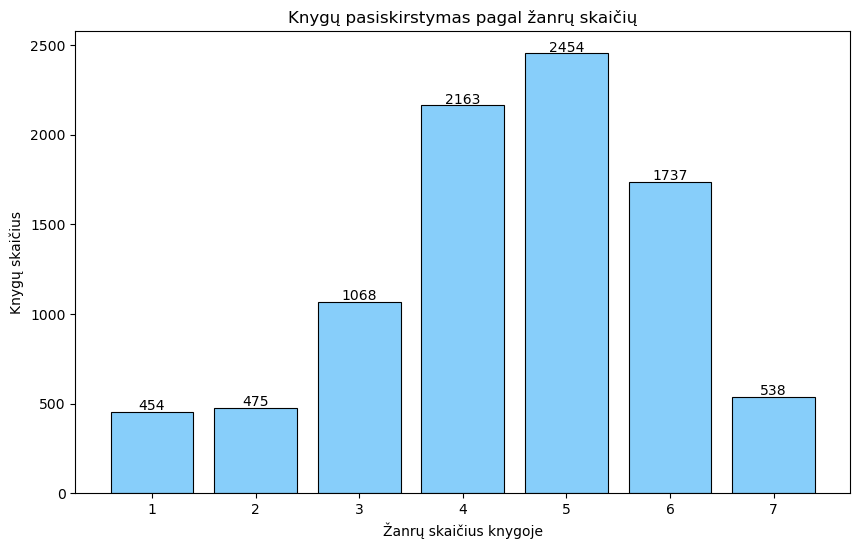

In [13]:
plt.figure(figsize=(10,6))
plt.bar(genre_counts.index, genre_counts.values, color="lightskyblue",  edgecolor="black", linewidth=0.8)
plt.xlabel("Žanrų skaičius knygoje")
plt.ylabel("Knygų skaičius")
plt.title("Knygų pasiskirstymas pagal žanrų skaičių")
plt.xticks(genre_counts.index)

for x, y in zip(genre_counts.index, genre_counts.values):
    plt.text(x, y + 10, str(y), ha='center')

plt.show()

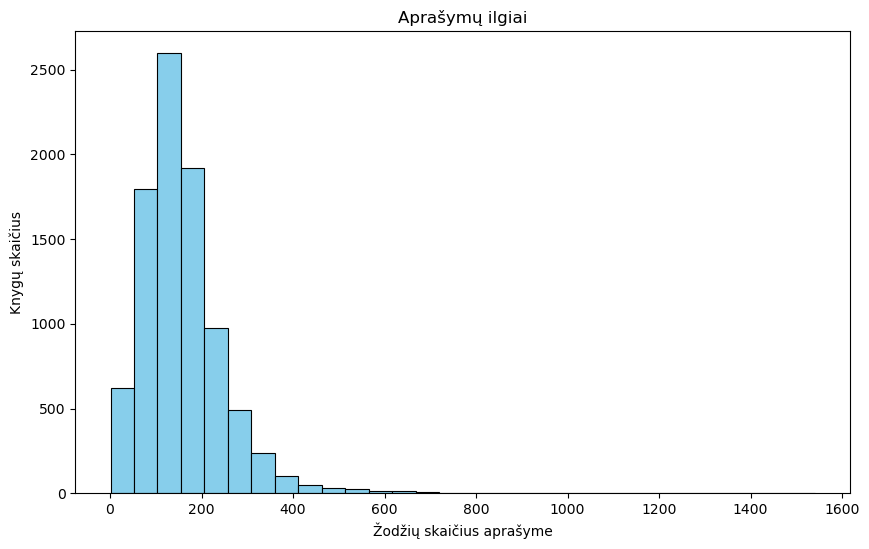

In [14]:
df['desc_length'] = df['Description'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
plt.hist(
    df['desc_length'],
    bins=30,
    color="skyblue",
    edgecolor="black",
    linewidth=0.8
)

plt.xlabel("Žodžių skaičius aprašyme")
plt.ylabel("Knygų skaičius")
plt.title("Aprašymų ilgiai")
plt.show()


In [15]:
desc_length_counts = df['desc_length'].value_counts().sort_index()
print("Žodžių skaičius aprašyme | Knygų skaičius")
print("-----------------------------------------")
for length, count in desc_length_counts.items():
    print(f"{length:<25} {count}")

Žodžių skaičius aprašyme | Knygų skaičius
-----------------------------------------
1                         9
2                         5
3                         3
4                         11
5                         8
6                         5
7                         7
8                         5
9                         1
10                        6
11                        2
12                        3
13                        3
14                        2
15                        6
16                        4
17                        5
18                        5
19                        6
20                        11
21                        7
22                        4
23                        3
24                        7
25                        17
26                        9
27                        10
28                        12
29                        8
30                        8
31                        10
32                        15
33           

In [16]:
bins = [0, 50, 100, 150, 200, 300, 500, 1000]  # intervalai žodžių skaičiui
labels = ["0-50","51-100","101-150","151-200","201-300","301-500","501-1000"]

df['desc_bin'] = pd.cut(df['desc_length'], bins=bins, labels=labels, right=False)
desc_bin_counts = df['desc_bin'].value_counts().sort_index()

print("Žodžių intervalas | Knygų skaičius")
print("-------------------------------")
for interval, count in desc_bin_counts.items():
    print(f"{interval:<15} {count}")

Žodžių intervalas | Knygų skaičius
-------------------------------
0-50            544
51-100          1690
101-150         2545
151-200         1964
201-300         1574
301-500         502
501-1000        65


Pašaliname knygas, kurių aprašymas trumpesni nei 50 žodžių.

In [17]:
# Suskaiciuojame zodziu skaiciu aprasyme
df['desc_length'] = df['Description'].apply(lambda x: len(str(x).split()))

# Saliname knygas, kuriu aprasymas trumpesni nei 50 zodziu.
drop_indices = df[df['desc_length'] < 50].index

df = df.drop(drop_indices)

print("Po filtravimo liko knygų:", len(df))


Po filtravimo liko knygų: 8345


In [18]:
# Saliname knygas, kuriu aprasymas buvo nelotyniskomis raidemis
def has_latin(text):
    if pd.isna(text):
        return False
    return bool(re.search(r'[A-Za-z]', str(text)))

mask_book = df['Book'].apply(has_latin)
mask_desc = df['Description'].apply(has_latin)

removed = df[~(mask_book & mask_desc)]

print("Pašalintų knygų indeksai:")
print(removed.index.tolist())

print("\nPašalintų knygų skaičius:", len(removed))

df = df[mask_book & mask_desc]

print("\nPo filtro liko knygų:", len(df))


Pašalintų knygų indeksai:
[6, 93, 247, 446, 472, 541, 657, 1144, 1295, 1834, 2029, 2231, 2547, 3236, 3322, 3458, 3795, 3843, 4049, 4213, 4511, 4554, 4665, 4672, 4739, 4892, 4916, 5009, 5108, 5333, 5340, 5409, 5516, 5532, 6086, 6114, 6116, 6196, 6283, 6310, 6353, 6402, 6442, 6661, 6716, 6795, 6903, 7148, 7616, 7883, 8126, 8269, 8605, 8630, 8719, 8729, 8757, 8865, 8866, 8966, 9059, 9389, 9415, 9419, 9570, 9606, 9742, 9790, 9829, 9893]

Pašalintų knygų skaičius: 70

Po filtro liko knygų: 8275


Skaidome duomenis į mokymo, validavimo ir testavimo aibę

In [19]:
X = df['Description'].values
y = df['Genres_list'].values

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.1, random_state=SEED, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1111, random_state=SEED, shuffle=True
)

print("Train:", len(X_train))       
print("Validation:", len(X_val))   
print("Test:", len(X_test))        


Train: 6619
Validation: 828
Test: 828


# TDF-IDF vektorizavimas

In [20]:
tfidf = TfidfVectorizer(
    max_features=2500,
    stop_words='english',
    lowercase=True    
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)


print("TF-IDF shapes:", X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)

mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train)
y_val_bin = mlb.transform(y_val)
y_test_bin = mlb.transform(y_test)

print("Y shapes:", y_train_bin.shape, y_val_bin.shape, y_test_bin.shape)
print("Žymų sąrašas:", mlb.classes_)

TF-IDF shapes: (6619, 2500) (828, 2500) (828, 2500)
Y shapes: (6619, 43) (828, 43) (828, 43)
Žymų sąrašas: ['Adult' 'Adventure' 'Biography' 'Business' 'Childrens' 'Classics'
 'Contemporary' 'Crime' 'Drama' 'Dystopia' 'Fantasy' 'Fiction'
 'Historical' 'Historical Fiction' 'History' 'Horror' 'Humor'
 'Literary Fiction' 'Literature' 'Magic' 'Memoir' 'Middle Grade' 'Mystery'
 'Mystery Thriller' 'Nonfiction' 'Novels' 'Paranormal'
 'Personal Development' 'Philosophy' 'Politics' 'Psychology' 'Religion'
 'Romance' 'Science' 'Science Fiction' 'Science Fiction Fantasy'
 'Self Help' 'Short Stories' 'Spirituality' 'Suspense' 'Thriller' 'War'
 'Young Adult']


In [21]:
for i in range(3):
    print(f"\n--- Knyga #{i} ---")

    try:
        print(f"Originalūs žanrai:   {y_train[i]}")
    except:
        pass

    print(f"Binarinis vektorius: {y_train_bin[i]}")

    atversta = mlb.inverse_transform(y_train_bin[i:i+1])
    print(f"Atkoduota iš bin:    {atversta[0]}")


--- Knyga #0 ---
Originalūs žanrai:   ['Horror', 'Fiction', 'Science Fiction', 'Fantasy', 'Dystopia']
Binarinis vektorius: [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0]
Atkoduota iš bin:    ('Dystopia', 'Fantasy', 'Fiction', 'Horror', 'Science Fiction')

--- Knyga #1 ---
Originalūs žanrai:   ['Short Stories', 'Fiction', 'Literature', 'Contemporary', 'Literary Fiction']
Binarinis vektorius: [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0]
Atkoduota iš bin:    ('Contemporary', 'Fiction', 'Literary Fiction', 'Literature', 'Short Stories')

--- Knyga #2 ---
Originalūs žanrai:   ['Young Adult', 'Contemporary', 'Fiction', 'Romance']
Binarinis vektorius: [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1]
Atkoduota iš bin:    ('Contemporary', 'Fiction', 'Romance', 'Young Adult')


In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

architectures = [(32,), (64,), (128, 64)]
EPOCHS = 150
PATIENCE = 15

# Atkoduojame žanrus
y_train_labels = mlb.inverse_transform(y_train_bin)
all_genres = [g for sublist in y_train_labels for g in sublist]

# Randame Top 10
genre_counts = Counter(all_genres)
top_10_names = [name for name, count in genre_counts.most_common(10)]
print(f"Top 10 populiariausių: {top_10_names}")

# Sukuriame 3 lygių masyvą
heuristic_thresholds = []

print("\nPriskiriami slenksčiai (Pavyzdžiai):")
for i, class_name in enumerate(mlb.classes_):

    # 1 LYGIS: pati populiariausia klasė - kuri išsikiria labai
    if class_name == 'Fiction':
        t = 0.5
        lvl = "Griežčiausias (Fiction)"

    # 2 LYGIS: Kiti iš Top 10 (išskyrus Fiction)
    elif class_name in top_10_names:
        t = 0.4
        lvl = "Vidutinis (Top 10)"

    # 3 LYGIS: Visi likę (reti)
    else:
        t = 0.3
        lvl = "Atlaidus (Retas)"

    heuristic_thresholds.append(t)

    # Atspausdiname patikrinimui kelis pavyzdžius
    if i < 5 or class_name == 'Fiction':
        print(f"  {class_name:<20} -> {t} [{lvl}]")

heuristic_thresholds = np.array(heuristic_thresholds)
print("\nSlenksčių masyvas paruoštas.\n")

# Mokymo ciklas su naujais slenksčiais

history = {}
best_models = {}

for arch in architectures:
    print(f"\n--- Pradedamas mokymas: {arch} ---")

    mlp = MLPClassifier(
        hidden_layer_sizes=arch,
        activation='relu',
        solver='adam',
        max_iter=1,
        warm_start=True,
        random_state=SEED,
        learning_rate_init=0.001,
        alpha=0.01
    )

    arch_history = {'train_micro': [], 'val_micro': []}
    best_val_score = -1
    best_model_state = None
    no_improve_count = 0

    for epoch in range(EPOCHS):
        mlp.fit(X_train_tfidf, y_train_bin)

        prob_val = mlp.predict_proba(X_val_tfidf)
        pred_val = (prob_val >= heuristic_thresholds).astype(int)

        f1_val_mic = f1_score(y_val_bin, pred_val, average='micro')

        arch_history['val_micro'].append(f1_val_mic)

        prob_train = mlp.predict_proba(X_train_tfidf)
        pred_train = (prob_train >= heuristic_thresholds).astype(int)
        f1_train_mic = f1_score(y_train_bin, pred_train, average='micro')
        arch_history['train_micro'].append(f1_train_mic)

        # ankstyvo stabdymo logika
        if f1_val_mic > best_val_score:
            best_val_score = f1_val_mic
            best_model_state = deepcopy(mlp)
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= PATIENCE:
            print(f"Stabdoma ties {epoch+1} epocha. Geriausias: {best_val_score:.4f}")
            break

    history[str(arch)] = arch_history
    if best_model_state is not None:
        best_models[str(arch)] = best_model_state

    print(f"Rezultatas {arch}: {best_val_score:.4f}")

# Išrenkame geriausia architektūrą (pagal val mikro F1 su heuristika)
winner_arch = None
best_overall_score = -1

for arch_name, model in best_models.items():
    val_prob = model.predict_proba(X_val_tfidf)
    val_pred = (val_prob >= heuristic_thresholds).astype(int)
    score = f1_score(y_val_bin, val_pred, average='micro')

    if score > best_overall_score:
        best_overall_score = score
        winner_arch = arch_name

print(f"Geriausia architektūra {winner_arch}")
final_model = best_models[winner_arch]

# GALUTINIAI REZULTATAI

val_prob = final_model.predict_proba(X_val_tfidf)
y_val_pred = (val_prob >= heuristic_thresholds).astype(int)

train_prob = final_model.predict_proba(X_train_tfidf)
y_train_pred = (train_prob >= heuristic_thresholds).astype(int)

# F1
val_f1_micro  = f1_score(y_val_bin, y_val_pred, average='micro')
val_f1_macro  = f1_score(y_val_bin, y_val_pred, average='macro')
train_f1_micro = f1_score(y_train_bin, y_train_pred, average='micro')
train_f1_macro = f1_score(y_train_bin, y_train_pred, average='macro')

from sklearn.metrics import accuracy_score

val_acc = accuracy_score(y_val_bin, y_val_pred)
train_acc = accuracy_score(y_train_bin, y_train_pred)


Top 10 populiariausių: ['Fiction', 'Nonfiction', 'Fantasy', 'Classics', 'Young Adult', 'Romance', 'Historical Fiction', 'Mystery', 'Contemporary', 'Novels']

Priskiriami slenksčiai (Pavyzdžiai):
  Adult                -> 0.3 [Atlaidus (Retas)]
  Adventure            -> 0.3 [Atlaidus (Retas)]
  Biography            -> 0.3 [Atlaidus (Retas)]
  Business             -> 0.3 [Atlaidus (Retas)]
  Childrens            -> 0.3 [Atlaidus (Retas)]
  Fiction              -> 0.5 [Griežčiausias (Fiction)]

Slenksčių masyvas paruoštas.


--- Pradedamas mokymas: (32,) ---
Stabdoma ties 60 epocha. Geriausias: 0.6132
Rezultatas (32,): 0.6132

--- Pradedamas mokymas: (64,) ---


In [ ]:

print("\n Geriausios architektūros rezultatai")

print(f"Train Accuracy:      {train_acc:.4f}")
print(f"Train Micro F1:      {train_f1_micro:.4f}")
print(f"Train Macro F1:      {train_f1_macro:.4f}")

print("---------------------------------------")

print(f"Val Accuracy:        {val_acc:.4f}")
print(f"Val Micro F1:        {val_f1_micro:.4f}")
print(f"Val Macro F1:        {val_f1_macro:.4f}")



In [ ]:
plt.figure(figsize=(12, 6))
colors = ['lime', 'magenta', 'cyan']
for i, arch in enumerate(history):
    data = history[arch]
    c = colors[i % len(colors)]
    if len(data['train_micro']) > 0:
        plt.plot(data['train_micro'], linestyle='-', color=c, alpha=0.4, label=f'Train {arch}')
        plt.plot(data['val_micro'], linestyle='--', color=c, linewidth=2, label=f'Val {arch}')

plt.title("F1 micro kitimas skirtingose architektūrose per epochas")
plt.xlabel("Epochos")
plt.ylabel("Micro F1")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("VISŲ BANDYTŲ ARCHITEKTŪRŲ REZULTATAI (VALIDATION SET)")
print(f"{'Architektūra':<20} | {'Accuracy':<10} | {'Micro F1':<10} | {'Macro F1':<10}")
print("-" * 65)

for arch_key, model in best_models.items():

    val_prob = model.predict_proba(X_val_tfidf)

    val_pred = (val_prob >= heuristic_thresholds).astype(int)

    acc = accuracy_score(y_val_bin, val_pred)
    mic = f1_score(y_val_bin, val_pred, average='micro')
    mac = f1_score(y_val_bin, val_pred, average='macro')

    print(f"{arch_key:<20} | {acc:.4f}     | {mic:.4f}     | {mac:.4f}")

print("-" * 65)

# Word2vec

In [ ]:
mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train)
y_val_bin   = mlb.transform(y_val)
y_test_bin  = mlb.transform(y_test)

# Salinama nereiksmingi zodziai

from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

# Saliname skyrybos zneklus ir paverciama mazosiomis raidemis
def clean(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.split()

train_tokens = [clean(t) for t in X_train]
val_tokens   = [clean(t) for t in X_val]
test_tokens  = [clean(t) for t in X_test]


w2v = Word2Vec(sentences=train_tokens, vector_size=200, window=30, min_count=1, workers=4, sg=1)

# Teksto vertimo i vektorius funkcija
def to_vec(tokens):
    vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
    if len(vecs) == 0:
        return np.zeros(w2v.vector_size)
    return np.mean(vecs, axis=0)

# Transformuojame
X_train_vec = np.array([to_vec(t) for t in train_tokens])
X_val_vec   = np.array([to_vec(t) for t in val_tokens])
X_test_vec  = np.array([to_vec(t) for t in test_tokens])

# Skaliname data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_vec)
X_val_scaled   = scaler.transform(X_val_vec)
X_test_scaled  = scaler.transform(X_test_vec)


In [ ]:
architectures = [(64,), (128, 64), (256, 128)]

# Atkoduojame žanrus
y_train_labels = mlb.inverse_transform(y_train_bin)
all_genres = [g for sublist in y_train_labels for g in sublist]

# Randame Top 10
genre_counts = Counter(all_genres)
top_10_names = [name for name, count in genre_counts.most_common(10)]
print(f"Top 10 populiariausių: {top_10_names}")

# Sukuriame 3 lygių masyvą
heuristic_thresholds = []

print("\nPriskiriami slenksčiai (Pavyzdžiai):")
for i, class_name in enumerate(mlb.classes_):

    # 1 LYGIS: pati populiariausia klasė - kuri išsikiria labai
    if class_name == 'Fiction':
        t = 0.5
        lvl = "Griežčiausias (Fiction)"

    # 2 LYGIS: Kiti iš Top 10 (išskyrus Fiction)
    elif class_name in top_10_names:
        t = 0.4
        lvl = "Vidutinis (Top 10)"

    # 3 LYGIS: Visi likę (reti)
    else:
        t = 0.3
        lvl = "Atlaidus (Retas)"

    heuristic_thresholds.append(t)

    # Atspausdiname patikrinimui kelis pavyzdžius
    if i < 5 or class_name == 'Fiction':
        print(f"  {class_name:<20} -> {t} [{lvl}]")

heuristic_thresholds = np.array(heuristic_thresholds)
print("\nSlenksčių masyvas paruoštas.\n")

# Mokymo ciklas su naujais slenksčiais

history = {}
best_models = {}

for arch in architectures:
    print(f"\n--- Pradedamas mokymas: {arch} ---")

    mlp = MLPClassifier(
        hidden_layer_sizes=arch,
        activation='relu',
        solver='adam',
        max_iter=1,
        warm_start=True,
        random_state=SEED,
        learning_rate_init=0.001,
        alpha=0.01
    )

    arch_history = {'train_micro': [], 'val_micro': []}
    best_val_score = -1
    best_model_state = None
    no_improve_count = 0

    for epoch in range(EPOCHS):
        mlp.fit(X_train_scaled, y_train_bin)

        prob_val = mlp.predict_proba(X_val_scaled)
        pred_val = (prob_val >= heuristic_thresholds).astype(int)

        f1_val_mic = f1_score(y_val_bin, pred_val, average='micro')

        arch_history['val_micro'].append(f1_val_mic)

        prob_train = mlp.predict_proba(X_train_scaled)
        pred_train = (prob_train >= heuristic_thresholds).astype(int)
        f1_train_mic = f1_score(y_train_bin, pred_train, average='micro')
        arch_history['train_micro'].append(f1_train_mic)

        # Ankstyvo sustojimo logika
        if f1_val_mic > best_val_score:
            best_val_score = f1_val_mic
            best_model_state = deepcopy(mlp)
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= PATIENCE:
            print(f"Stabdoma ties {epoch+1} epocha. Geriausias: {best_val_score:.4f}")
            break

    history[str(arch)] = arch_history
    if best_model_state is not None:
        best_models[str(arch)] = best_model_state
        
    final_model = best_model_state

    train_pred = (final_model.predict_proba(X_train_scaled) >= heuristic_thresholds).astype(int)
    val_pred   = (final_model.predict_proba(X_val_scaled)   >= heuristic_thresholds).astype(int)

    train_micro = f1_score(y_train_bin, train_pred, average='micro')
    train_macro = f1_score(y_train_bin, train_pred, average='macro')
    train_acc   = accuracy_score(y_train_bin, train_pred)

    val_micro   = f1_score(y_val_bin, val_pred, average='micro')
    val_macro   = f1_score(y_val_bin, val_pred, average='macro')
    val_acc     = accuracy_score(y_val_bin, val_pred)


    print(f"Rezultatas {arch}: {best_val_score:.4f}")
    print(f"  Train Accuracy: {train_acc:.4f}, Micro F1: {train_micro:.4f}, Macro F1: {train_macro:.4f}")
    print(f"  Val   Accuracy: {val_acc:.4f}, Micro F1: {val_micro:.4f}, Macro F1: {val_macro:.4f}")


# Išrenkame geriausia architektūrą (pagal val mikro F1 su heuristika)
winner_arch = None
best_overall_score = -1

for arch_name, model in best_models.items():
    val_prob = model.predict_proba(X_val_scaled)
    val_pred = (val_prob >= heuristic_thresholds).astype(int)
    score = f1_score(y_val_bin, val_pred, average='micro')

    if score > best_overall_score:
        best_overall_score = score
        winner_arch = arch_name

print(f" Geriausia architektūra {winner_arch}")
final_model = best_models[winner_arch]

In [ ]:
val_prob = final_model.predict_proba(X_val_scaled)
y_val_pred = (val_prob >= heuristic_thresholds).astype(int)

train_prob = final_model.predict_proba(X_train_scaled)
y_train_pred = (train_prob >= heuristic_thresholds).astype(int)

# F1
val_f1_micro  = f1_score(y_val_bin, y_val_pred, average='micro')
val_f1_macro  = f1_score(y_val_bin, y_val_pred, average='macro')
train_f1_micro = f1_score(y_train_bin, y_train_pred, average='micro')
train_f1_macro = f1_score(y_train_bin, y_train_pred, average='macro')

val_acc = accuracy_score(y_val_bin, y_val_pred)
train_acc = accuracy_score(y_train_bin, y_train_pred)

print("\n Galutiniai rezultatai")

print(f"Train Accuracy:      {train_acc:.4f}")
print(f"Train Micro F1:      {train_f1_micro:.4f}")
print(f"Train Macro F1:      {train_f1_macro:.4f}")

print("---------------------------------------")

print(f"Val Accuracy:        {val_acc:.4f}")
print(f"Val Micro F1:        {val_f1_micro:.4f}")
print(f"Val Macro F1:        {val_f1_macro:.4f}")




In [ ]:
plt.figure(figsize=(12, 6))
colors = ['lime', 'magenta', 'cyan']

for i, arch in enumerate(history):
    data = history[arch]
    c = colors[i % len(colors)]
    if len(data['train_micro']) > 0:
        plt.plot(data['train_micro'], linestyle='-', color=c, alpha=0.4, label=f'Train {arch}')
        plt.plot(data['val_micro'], linestyle='--', color=c, linewidth=2, label=f'Val {arch}')

plt.title("F1 micro kitimas skirtingose architektūrose per epochas")
plt.xlabel("Epochos")
plt.ylabel("Micro F1")
plt.legend()
plt.grid(True)
plt.show()

# Galutinio geriausio modelio testavimas

In [ ]:
test_prob = final_model.predict_proba(X_test_scaled)

test_pred = (test_prob >= heuristic_thresholds).astype(int)

test_acc = accuracy_score(y_test_bin, test_pred)
test_micro = f1_score(y_test_bin, test_pred, average="micro")
test_macro = f1_score(y_test_bin, test_pred, average="macro")

print(f"Test Accuracy:   {test_acc:.4f}")
print(f"Test Micro F1:   {test_micro:.4f}")
print(f"Test Macro F1:   {test_macro:.4f}")

print("\n Classification Report ")
print(classification_report(y_test_bin, test_pred, target_names=mlb.classes_))
